# Input

In [1]:
ls /home/luongnv/Documents/DataScience/Project-Tripi/data/cleaned-table/

district.csv                    hotel_price.csv        province.csv
full.csv                        hotel_price_daily.csv  rank1.csv
full.ipynb                      hotel_quality.csv      rank.csv
hotel_distance_to_location.csv  hotel_review.csv       show_4000.csv
hotel_facility.csv              hotel_service.csv      street.csv
hotel_location.csv              model.ipynb            top10.csv
hotel_map.csv                   Note.txt               top10_name.csv


In [2]:
DATA_PATH = '/home/luongnv/Documents/DataScience/Project-Tripi/data/table/others/hotel_logging.csv'

# Import

In [3]:
# !pip install gensim

In [4]:
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import sqlite3

from gensim.models import Word2Vec
import multiprocessing

# Preprocessing

In [6]:
dataset = pd.read_csv(DATA_PATH)
print(dataset.shape)
dataset.head(5)

/home/luongnv/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(4622366, 30)


,id,action_name,user_id,device_id,session_id,ip_address,hotel_id,checkin_date,checkout_date,room_num,...,order_id,price,overall_score,star_number,reviews_number,rating_level,promo_code,created_at,created_date_id,created_datetime
0,00008bd1-6ab2-4e03-bff8-5d16a177b584,1_search,11334705507972639891,17640740255792518705,13952697554481104298,14.169.81.139,152,2020-06-20,2020-06-21,1.0,...,,15135000.0,80.0,5.0,827.0,4.0,,1591888517,20200611,2020-06-11 15:15:17
1,0000d332-788b-4d8d-851f-5108d1a4ccaf,1_search,8906156722961307698,10367553389187641383,9810619657510224095,1.53.49.250,45056,2020-06-19,2020-06-22,1.0,...,,440000.0,80.0,1.0,-1.0,4.0,,1591851465,20200611,2020-06-11 04:57:45
2,00023dc4-7dd9-44c7-9f9f-53ece6add1c3,1_search,8713586429204036026,2634317312779843568,5765690825377299953,171.234.219.83,41237,2020-06-26,2020-06-28,2.0,...,,630000.0,83.0,3.0,18.0,4.0,,1591809530,20200611,2020-06-10 17:18:50
3,00038961-60dd-4e7b-9f91-62590775ae3b,1_search,10261094556439181748,10046195434681205429,11088181932661319572,58.187.2.44,35590,2020-06-12,2020-06-13,1.0,...,,651000.0,83.0,3.0,-1.0,4.0,,1591873502,20200611,2020-06-11 11:05:02
4,000458bc-e505-482b-a847-2ff4dd146a27,1_search,3590635501695286080,3844843270772722622,10651650068540650999,27.79.101.49,29869,2020-06-13,2020-06-14,1.0,...,,1063000.0,81.0,2.0,15.0,4.0,,1591890108,20200611,2020-06-11 15:41:48


In [7]:
dataset[['action_name']].value_counts()

action_name   
1_search          4461636
2_click_detail      80395
2_click             77648
3_book               2687
dtype: int64

# Merge with 4000 hotels

In [39]:
_4000_PATH = '/home/luongnv/Documents/DataScience/Project-Tripi/data/cleaned-table/show_4000.csv'
_4000_hotels = pd.read_csv(_4000_PATH)
hotel_id = _4000_hotels[['hotel_id']]
hotel_id.T

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
hotel_id,39339,42896,30354,3460,41862,9088,42485,42647,40302,35015,...,44214,4716,9135,43010,46116,44066,45962,42417,42919,38023


In [43]:
search = hotel_id.merge(dataset, on='hotel_id')

# 2_click Data

In [51]:
cols = ['user_id', 'created_datetime', 'hotel_id', 'action_name', 'session_id']

data = search[cols] # .sample(2000, random_state=0)
data = data[data['action_name'] == '2_click']
data.T

,856,1164,1403,1429,1474,1479,1507,1741,1785,2256,...,590932,590967,590985,591034,591049,591125,591129,591145,591184,591296
user_id,10300358058667003563,11231319847156771476,17601196623310568924,6338668372765433652,6654724024205234272,6654724024205234272,6338668372765433652,11055881110915305754,16677141897191501587,11977787794348193843,...,2317769521819324818,1004394970027613813,6654724024205234272,14506582882338325308,6976144503574788117,6654724024205234272,6654724024205234272,6654724024205234272,2452195815121021547,6654724024205234272
created_datetime,2020-07-07 13:11:24,2020-06-25 00:56:10,2020-06-30 12:21:22,2020-07-01 01:01:34,2020-07-28 09:27:38,2020-07-28 05:14:50,2020-07-06 06:12:46,2020-06-13 10:02:56,2020-06-13 04:50:27,2020-07-21 15:52:24,...,2020-07-21 14:44:54,2020-07-22 14:49:26,2020-07-23 15:36:33,2020-07-01 00:27:29,2020-07-25 01:33:25,2020-07-03 17:12:27,2020-07-05 09:26:47,2020-07-06 07:54:37,2020-08-06 14:53:55,2020-07-22 07:34:18
hotel_id,30354,41862,42647,42647,42647,42647,42647,38570,38570,38570,...,9135,9135,9135,9135,9135,9135,9135,9135,9135,46116
action_name,2_click,2_click,2_click,2_click,2_click,2_click,2_click,2_click,2_click,2_click,...,2_click,2_click,2_click,2_click,2_click,2_click,2_click,2_click,2_click,2_click
session_id,3353860652385339321,17759949149591123076,14905344184719718202,9911714336603072809,16828519558456157434,15506403340010340743,12212118020961406639,2315936342737092938,5801897873288344664,15166533902522448254,...,5852360564933339327,730380603461356814,13570364319464573158,8260932802693457736,106218743286099842,14478164351397346326,1868585256309075784,7153406073944544050,3828396320315497230,4755171926417958618


In [52]:
data[['hotel_id']].value_counts()

hotel_id
40415       468
45572       380
45545       213
2101        193
40412       187
           ... 
42879         1
42899         1
21888         1
45144         1
47657         1
Length: 820, dtype: int64

> Thực hiện format lại trường datetime và sắp xếp theo chiều thời gian:

In [53]:
data['created_datetime'] = data['created_datetime'].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S'))
data.sort_values('created_datetime', ascending=True, inplace=True)
data

,user_id,created_datetime,hotel_id,action_name,session_id
529365,15723443244389963611,2020-06-11 07:22:00,40413,2_click,11902710566263368450
36293,9932722335577120441,2020-06-11 07:32:34,39917,2_click,14847576686992545488
499035,3443285658761118599,2020-06-11 07:43:24,45005,2_click,14590856588606409332
391244,4108375683180746629,2020-06-11 07:57:09,43280,2_click,17032867769091145666
61535,9114710392698631834,2020-06-11 07:57:21,40454,2_click,1249138355582623363
...,...,...,...,...,...
515276,2148708592572271783,2020-08-11 15:12:31,9627,2_click,14262390446224313751
372653,14474231321677733516,2020-08-11 15:57:58,46685,2_click,9708051136698869758
440616,3329369102191579092,2020-08-11 16:18:14,33340,2_click,7856873733871269158
439559,3329369102191579092,2020-08-11 16:20:14,33857,2_click,7856873733871269158


> Phân bố dữ liệu tại trường hotel_id:

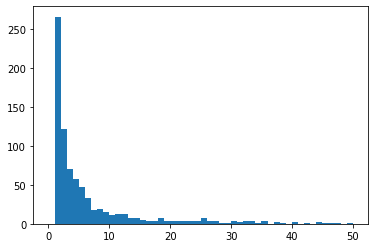

In [54]:
_ = plt.hist(data["hotel_id"].value_counts().values, bins=50, range=(0, 50))

> Lấy hotel_id sau từng user_id cụ thể (về thực tế không cần quan tâm user là ai)

In [55]:
start = time.time()
sessions = []
for user_id, df in data.groupby('user_id', sort=False):
    session = []
    for index, row in df.iterrows():
        session.append(str(row['hotel_id']))
  
    sessions.append(session)
    
print("Took {}'s".format(time.time() - start))

print(sessions[0])

Took 1.1076512336730957's
['40413']


In [84]:
for user_id, df in data.groupby('user_id', sort=False):
    print(df)

                     user_id    created_datetime  hotel_id action_name  \
529365  15723443244389963611 2020-06-11 07:22:00     40413     2_click   

                  session_id  
529365  11902710566263368450  
                   user_id    created_datetime  hotel_id action_name  \
36293  9932722335577120441 2020-06-11 07:32:34     39917     2_click   

                 session_id  
36293  14847576686992545488  
                    user_id    created_datetime  hotel_id action_name  \
499035  3443285658761118599 2020-06-11 07:43:24     45005     2_click   
371140  3443285658761118599 2020-06-13 14:10:16     41382     2_click   
371138  3443285658761118599 2020-06-13 14:10:18     41382     2_click   

                  session_id  
499035  14590856588606409332  
371140  14310791494286568425  
371138  14310791494286568425  
                    user_id    created_datetime  hotel_id action_name  \
391244  4108375683180746629 2020-06-11 07:57:09     43280     2_click   
139043  4108375683180

                    user_id    created_datetime  hotel_id action_name  \
510533  9747445107423253077 2020-06-12 10:51:51       869     2_click   

                session_id  
510533  894783234387324221  
                    user_id    created_datetime  hotel_id action_name  \
72450  16270332568343593575 2020-06-12 11:06:01     44551     2_click   

                 session_id  
72450  14770657063870302339  
                    user_id    created_datetime  hotel_id action_name  \
150081  4210121857798953459 2020-06-12 11:31:36     41187     2_click   

                  session_id  
150081  15389251504556721709  
                     user_id    created_datetime  hotel_id action_name  \
550435  17370407713014212824 2020-06-12 12:03:24     21738     2_click   

                 session_id  
550435  6011994638471282663  
                    user_id    created_datetime  hotel_id action_name  \
374085  3894647855198642336 2020-06-12 12:10:53     40415     2_click   
541160  3894647855198642

506176  4660585434312469003  
                     user_id    created_datetime  hotel_id action_name  \
374228  18237966656375158560 2020-06-13 14:08:43     40415     2_click   

                  session_id  
374228  16985240362158680010  
                     user_id    created_datetime  hotel_id action_name  \
374383  10374282528577021696 2020-06-13 14:09:47     40415     2_click   
527082  10374282528577021696 2020-06-18 11:45:27     45627     2_click   

                 session_id  
374383  9582284042069302840  
527082  9902535420166607657  
                     user_id    created_datetime  hotel_id action_name  \
374123  11200090809209641266 2020-06-13 14:10:36     40415     2_click   

                 session_id  
374123  4087724308509681073  
                     user_id    created_datetime  hotel_id action_name  \
374230  13213024971134330370 2020-06-13 14:11:08     40415     2_click   

                 session_id  
374230  9082245194791491179  
                     user_id

71552  10279673871707783810  
                    user_id    created_datetime  hotel_id action_name  \
150163  6826362522083449264 2020-06-15 05:49:18     41187     2_click   
10635   6826362522083449264 2020-06-17 02:29:27     39120     2_click   
10692   6826362522083449264 2020-06-17 02:30:23     39120     2_click   
10686   6826362522083449264 2020-06-17 12:28:49     39120     2_click   
10735   6826362522083449264 2020-06-18 01:22:54     39120     2_click   
10737   6826362522083449264 2020-06-18 01:24:56     39120     2_click   
10711   6826362522083449264 2020-06-18 01:33:07     39120     2_click   
10724   6826362522083449264 2020-06-18 02:43:16     39120     2_click   
10708   6826362522083449264 2020-06-18 02:54:35     39120     2_click   
10720   6826362522083449264 2020-06-18 02:57:47     39120     2_click   
10773   6826362522083449264 2020-06-19 02:30:47     39120     2_click   
10799   6826362522083449264 2020-06-19 02:31:38     39120     2_click   
10798   6826362522083

504847   1913973128325842846  
                     user_id    created_datetime  hotel_id action_name  \
104780  10366420890567331629 2020-06-16 14:54:29      2101     2_click   
347893  10366420890567331629 2020-06-16 15:18:05     35365     2_click   
294564  10366420890567331629 2020-06-16 15:21:30      1216     2_click   
222654  10366420890567331629 2020-06-19 07:30:34     35139     2_click   
528687  10366420890567331629 2020-06-19 14:56:03     41419     2_click   

                 session_id  
104780  8197274246188495235  
347893  8197274246188495235  
294564  8197274246188495235  
222654  3604621830626490603  
528687  8768524660961373518  
                    user_id    created_datetime  hotel_id action_name  \
452904  4983886941510986568 2020-06-16 14:58:24     29480     2_click   
227816  4983886941510986568 2020-06-16 15:05:09     45572     2_click   
227752  4983886941510986568 2020-06-16 15:12:28     45572     2_click   
227967  4983886941510986568 2020-06-17 01:40:25     

397885  12827172469823500191  
                     user_id    created_datetime  hotel_id action_name  \
408344  16720036397556485132 2020-06-18 08:30:35     40709     2_click   

                  session_id  
408344  18310498764062271470  
                    user_id    created_datetime  hotel_id action_name  \
133473  1846032344272420132 2020-06-18 09:24:14        32     2_click   
139365  1846032344272420132 2020-06-28 14:31:08     29494     2_click   

                  session_id  
133473  17285033153986705176  
139365  11766814829685291400  
                     user_id    created_datetime  hotel_id action_name  \
256308  12701163571855339815 2020-06-18 09:37:45     45275     2_click   

                 session_id  
256308  9232523170111030581  
                    user_id    created_datetime  hotel_id action_name  \
153627  2354002723317118465 2020-06-18 09:39:53      6126     2_click   

                 session_id  
153627  2278268416277207148  
                  user_id    

249269  1480449353286572136  
                     user_id    created_datetime  hotel_id action_name  \
123298  15872113874921525688 2020-06-20 14:17:20     37364     2_click   

                  session_id  
123298  12160454274090495787  
                   user_id    created_datetime  hotel_id action_name  \
105582  407316718151471728 2020-06-20 14:36:44      2101     2_click   

                 session_id  
105582  1450742939144326600  
                    user_id    created_datetime  hotel_id action_name  \
62324   4698873669451475529 2020-06-20 14:53:29     40454     2_click   
374778  4698873669451475529 2020-06-20 14:55:53     40415     2_click   
438752  4698873669451475529 2020-06-20 15:52:21     44212     2_click   
256953  4698873669451475529 2020-06-27 08:35:36     45275     2_click   
542976  4698873669451475529 2020-07-01 08:14:17      3538     2_click   
542974  4698873669451475529 2020-07-01 08:14:35      3538     2_click   
542973  4698873669451475529 2020-07-01 08:1

319367   4090899765943586107  
                     user_id    created_datetime  hotel_id action_name  \
555333  16244529376479173123 2020-06-22 13:00:01     41459     2_click   

                  session_id  
555333  13945447564083115480  
                     user_id    created_datetime  hotel_id action_name  \
43471   15399240045818042100 2020-06-22 13:09:43     29419     2_click   
172143  15399240045818042100 2020-06-22 13:11:08     40412     2_click   

                 session_id  
43471   5741810745290130308  
172143  5741810745290130308  
                     user_id    created_datetime  hotel_id action_name  \
62498   16486251865421323742 2020-06-22 13:35:55     40454     2_click   
128590  16486251865421323742 2020-06-23 05:03:04       436     2_click   

                 session_id  
62498   9428735095645601252  
128590  6177456970243830416  
                    user_id    created_datetime  hotel_id action_name  \
303479  6016391342843362672 2020-06-22 14:01:30     36483  

                    user_id    created_datetime  hotel_id action_name  \
539838  9174509846016001421 2020-06-25 02:34:20     38420     2_click   
454123  9174509846016001421 2020-06-25 03:44:40     29480     2_click   
539899  9174509846016001421 2020-06-25 03:49:43     38420     2_click   
539901  9174509846016001421 2020-06-25 03:51:23     38420     2_click   
539880  9174509846016001421 2020-06-25 06:57:33     38420     2_click   
454143  9174509846016001421 2020-06-25 06:59:15     29480     2_click   
229062  9174509846016001421 2020-06-25 07:13:20     45572     2_click   
540137  9174509846016001421 2020-06-26 18:19:01     38420     2_click   
540116  9174509846016001421 2020-06-26 18:19:51     38420     2_click   
229185  9174509846016001421 2020-06-26 18:27:31     45572     2_click   

                  session_id  
539838  13736565779424680866  
454123    248600812670851359  
539899    248600812670851359  
539901    248600812670851359  
539880  16565878953477421269  
454143  16

                    user_id    created_datetime  hotel_id action_name  \
107289  9223379784881834394 2020-06-27 16:27:38      2101     2_click   

                 session_id  
107289  1320563239823204630  
                     user_id    created_datetime  hotel_id action_name  \
550443  13482152222386708117 2020-06-27 16:37:13     44976     2_click   

                 session_id  
550443  4533310458995024399  
                     user_id    created_datetime  hotel_id action_name  \
463461  17234075814193618295 2020-06-27 17:00:51     40943     2_click   
463452  17234075814193618295 2020-06-27 17:02:31     40943     2_click   

                 session_id  
463461  7659614915809120864  
463452  7659614915809120864  
                     user_id    created_datetime  hotel_id action_name  \
540215  14823250066921618404 2020-06-27 17:56:44     38420     2_click   

                  session_id  
540215  14106343216463030184  
                    user_id    created_datetime  hotel_id ac

418337   7334905117661045055  
                     user_id    created_datetime  hotel_id action_name  \
394381  11587202525131103030 2020-07-01 03:38:29     41467     2_click   

                  session_id  
394381  12229633017399263287  
                     user_id    created_datetime  hotel_id action_name  \
229508  16078555259044265212 2020-07-01 04:19:03     45572     2_click   

                  session_id  
229508  17954483517184383279  
                     user_id    created_datetime  hotel_id action_name  \
375223  11816196284299723506 2020-07-01 04:24:26     40415     2_click   
375252  11816196284299723506 2020-07-01 04:28:22     40415     2_click   
375230  11816196284299723506 2020-07-01 04:32:19     40415     2_click   
375253  11816196284299723506 2020-07-01 04:33:04     40415     2_click   
375276  11816196284299723506 2020-07-01 05:00:23     40415     2_click   
...                      ...                 ...       ...         ...   
375625  11816196284299723506 

                     user_id    created_datetime  hotel_id action_name  \
225475  17072345216830404271 2020-07-03 10:22:32     40514     2_click   

                session_id  
225475  824364014090218447  
                   user_id    created_datetime  hotel_id action_name  \
139507  730113669451420154 2020-07-03 10:47:19     29494     2_click   

                 session_id  
139507  4175284966906677222  
                     user_id    created_datetime  hotel_id action_name  \
345091  12979391373888218325 2020-07-03 11:10:45        25     2_click   

                  session_id  
345091  11118560472104060419  
                     user_id    created_datetime  hotel_id action_name  \
108404  10293302434158208993 2020-07-03 11:13:13      2101     2_click   
106162  10293302434158208993 2020-07-18 08:22:47      2101     2_click   
295804  10293302434158208993 2020-07-18 08:35:33      1216     2_click   
65371   10293302434158208993 2020-07-22 12:35:39      3320     2_click   
293177 

                    user_id    created_datetime  hotel_id action_name  \
525614  1360817083146770427 2020-07-06 08:59:04     37664     2_click   
525620  1360817083146770427 2020-07-06 08:59:15     37664     2_click   
525622  1360817083146770427 2020-07-06 08:59:25     37664     2_click   
525624  1360817083146770427 2020-07-06 08:59:38     37664     2_click   
525615  1360817083146770427 2020-07-06 08:59:45     37664     2_click   
525621  1360817083146770427 2020-07-06 08:59:58     37664     2_click   
525617  1360817083146770427 2020-07-06 09:00:04     37664     2_click   
525599  1360817083146770427 2020-07-14 03:24:12     37664     2_click   

                  session_id  
525614   4056114223253813081  
525620   4056114223253813081  
525622   4056114223253813081  
525624   4056114223253813081  
525615   4056114223253813081  
525621   4056114223253813081  
525617   4056114223253813081  
525599  13629545698993594911  
                   user_id    created_datetime  hotel_id action

                    user_id    created_datetime  hotel_id action_name  \
27728   9297271169857999165 2020-07-09 15:36:49       242     2_click   
150058  9297271169857999165 2020-07-09 15:37:01     41187     2_click   
382945  9297271169857999165 2020-07-09 15:43:41     33375     2_click   
150044  9297271169857999165 2020-07-09 15:43:56     41187     2_click   
98788   9297271169857999165 2020-07-20 07:59:22       446     2_click   

                  session_id  
27728    4021590592294404056  
150058   4021590592294404056  
382945  16313684894798439045  
150044  16313684894798439045  
98788   10681040290670041167  
                    user_id    created_datetime  hotel_id action_name  \
373981  7305452724799762108 2020-07-09 15:37:33     40415     2_click   

                 session_id  
373981  1715097726361684141  
                    user_id    created_datetime  hotel_id action_name  \
458272  8859701814114279859 2020-07-09 15:43:16     41846     2_click   
503485  88597018141142

                    user_id    created_datetime  hotel_id action_name  \
98342  17536666150581149465 2020-07-13 14:40:05     22190     2_click   
90956  17536666150581149465 2020-07-13 14:47:35     42033     2_click   

                 session_id  
98342  17276871134013447504  
90956   4351838224289870039  
                    user_id    created_datetime  hotel_id action_name  \
319365  3636126429329497430 2020-07-13 14:40:38     21656     2_click   

                 session_id  
319365  4826445744444486345  
                     user_id    created_datetime  hotel_id action_name  \
145396  17725412871821666191 2020-07-13 14:45:42     45545     2_click   

                 session_id  
145396  9836397416724695070  
                     user_id    created_datetime  hotel_id action_name  \
294771  12797413321420098980 2020-07-13 15:05:17      1216     2_click   

                 session_id  
294771  8180171649271698333  
                  user_id    created_datetime  hotel_id action_na

                    user_id    created_datetime  hotel_id action_name  \
505762  6636230381014329141 2020-07-16 04:14:09     37442     2_click   

                 session_id  
505762  6121629924361129479  
                    user_id    created_datetime  hotel_id action_name  \
216281  7714700867091281852 2020-07-16 04:28:16     36421     2_click   
216288  7714700867091281852 2020-07-16 04:32:30     36421     2_click   
216283  7714700867091281852 2020-07-16 04:33:13     36421     2_click   
216280  7714700867091281852 2020-07-16 04:33:19     36421     2_click   

                  session_id  
216281  10350529404581786327  
216288  10350529404581786327  
216283  10350529404581786327  
216280  10350529404581786327  
                   user_id    created_datetime  hotel_id action_name  \
24349  5284487029750808966 2020-07-16 04:45:44     45726     2_click   

                 session_id  
24349  11673244174064676628  
                     user_id    created_datetime  hotel_id action_n

363197  5564312043363961082  
                    user_id    created_datetime  hotel_id action_name  \
106242  6048260804691315876 2020-07-19 06:43:17      2101     2_click   

                 session_id  
106242  7367138057037768069  
                     user_id    created_datetime  hotel_id action_name  \
503651  14545177774149037855 2020-07-19 06:55:55     41815     2_click   
438436  14545177774149037855 2020-07-20 01:30:45     41898     2_click   
503663  14545177774149037855 2020-07-20 01:42:11     41815     2_click   
438431  14545177774149037855 2020-07-20 02:02:44     41898     2_click   
438438  14545177774149037855 2020-07-20 16:57:02     41898     2_click   

                  session_id  
503651  15308774687562661968  
438436   9746776631980898567  
503663   9746776631980898567  
438431   9746776631980898567  
438438   3072433853649775314  
                    user_id    created_datetime  hotel_id action_name  \
394474  2894948852140437872 2020-07-19 07:03:37     22701  

2286  13729891729867745288  
                    user_id    created_datetime  hotel_id action_name  \
476867  8627992561701885624 2020-07-22 02:33:13      1158     2_click   
476864  8627992561701885624 2020-07-22 02:38:00      1158     2_click   
313205  8627992561701885624 2020-07-22 03:04:25     40945     2_click   
130633  8627992561701885624 2020-07-22 03:06:11      1764     2_click   
427146  8627992561701885624 2020-07-22 03:08:29      1194     2_click   

               session_id  
476867  79391323677834448  
476864  79391323677834448  
313205  79391323677834448  
130633  79391323677834448  
427146  79391323677834448  
                    user_id    created_datetime  hotel_id action_name  \
559014  9464423734348676235 2020-07-22 02:39:40      8145     2_click   

                 session_id  
559014  2361088027926985201  
                    user_id    created_datetime  hotel_id action_name  \
102667  4064865557874958323 2020-07-22 03:53:32       987     2_click   

          

139446  2162821237537926177  
                     user_id    created_datetime  hotel_id action_name  \
257168  13059634673567118989 2020-07-24 02:54:12     45275     2_click   

                  session_id  
257168  14874585845325458081  
                    user_id    created_datetime  hotel_id action_name  \
359569  6777889975831370389 2020-07-24 03:09:57     46676     2_click   
359564  6777889975831370389 2020-07-24 03:11:22     46676     2_click   

                 session_id  
359569  8009031899176716458  
359564  8009031899176716458  
                     user_id    created_datetime  hotel_id action_name  \
305535  14965199958720529757 2020-07-24 03:19:28     46968     2_click   

                  session_id  
305535  12831266902029343280  
                    user_id    created_datetime  hotel_id action_name  \
550445  9673301863564256642 2020-07-24 04:00:38     44976     2_click   
542971  9673301863564256642 2020-07-24 04:00:43     42337     2_click   
372668  96733018635

                    user_id    created_datetime  hotel_id action_name  \
166300  7240985949586995609 2020-07-26 13:23:00     39119     2_click   

                  session_id  
166300  15952059190835729842  
                   user_id    created_datetime  hotel_id action_name  \
86362  6285842495939070974 2020-07-26 13:29:28       393     2_click   

                session_id  
86362  2598156706305335832  
                     user_id    created_datetime  hotel_id action_name  \
474445  12275934720521577078 2020-07-26 14:13:16     45917     2_click   
215680  12275934720521577078 2020-07-26 14:14:07      4374     2_click   

                  session_id  
474445  18416248909057193537  
215680  18416248909057193537  
                    user_id    created_datetime  hotel_id action_name  \
147833  4197440874431245351 2020-07-26 14:35:39     45545     2_click   

                 session_id  
147833  1769250880496005182  
                     user_id    created_datetime  hotel_id action

230440  11775031275804658733  
                     user_id    created_datetime  hotel_id action_name  \
230445  10494494268119261598 2020-08-07 04:02:36     45572     2_click   
509440  10494494268119261598 2020-08-10 08:31:32     23116     2_click   
509409  10494494268119261598 2020-08-10 08:32:08     23116     2_click   
509422  10494494268119261598 2020-08-10 08:32:35     23116     2_click   
509402  10494494268119261598 2020-08-10 08:37:08     23116     2_click   
509411  10494494268119261598 2020-08-10 08:37:12     23116     2_click   
509434  10494494268119261598 2020-08-10 08:37:18     23116     2_click   
509407  10494494268119261598 2020-08-10 08:38:03     23116     2_click   
419450  10494494268119261598 2020-08-11 03:39:38      1180     2_click   

                  session_id  
230445  16953786460140356779  
509440   1426972404645447390  
509409   1426972404645447390  
509422   1426972404645447390  
509402   1426972404645447390  
509411   1426972404645447390  
509434   14

In [66]:
len(sessions)

2387

> Tách thành các nhóm n-gram theo n hotel_id liên tiếp được seach bời cùng 1 user

In [56]:
def make_ngrams(session, n=5):
    return list(zip(*[session[i:] for i in range(n)]))

In [92]:
session = sessions[2]
make_ngrams(session, n=3)

[('33340', '33857', '2594')]

> Thực hiện tạo 1 list các list chứa các hotel_id đã search trong 1 session_id

In [90]:
gen_sessions = []
for session in sessions:
    gen_sessions.extend(make_ngrams(session, 3))

print(len(gen_sessions))

5105


> Logging model trước lúc training:

In [93]:
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

> Training mô hình

In [94]:
gen_sessions

[('45005', '41382', '41382'),
 ('43280', '29494', '45477'),
 ('40454', '34', '40454'),
 ('34', '40454', '40412'),
 ('40454', '40412', '40415'),
 ('40412', '40415', '45572'),
 ('40415', '45572', '45572'),
 ('45572', '45572', '436'),
 ('45572', '436', '436'),
 ('436', '436', '22410'),
 ('436', '22410', '40454'),
 ('22410', '40454', '40412'),
 ('40454', '40412', '40454'),
 ('40412', '40454', '40454'),
 ('40454', '40454', '45572'),
 ('40454', '45572', '41571'),
 ('45572', '41571', '41571'),
 ('41571', '41571', '45078'),
 ('41571', '45078', '45545'),
 ('45078', '45545', '45545'),
 ('45545', '45545', '40431'),
 ('45545', '40431', '29494'),
 ('40431', '29494', '45545'),
 ('29494', '45545', '4859'),
 ('45545', '4859', '45572'),
 ('4859', '45572', '45572'),
 ('45572', '45572', '41307'),
 ('45572', '41307', '41176'),
 ('41307', '41176', '41176'),
 ('41176', '41176', '45572'),
 ('41176', '45572', '22235'),
 ('45572', '22235', '22235'),
 ('22235', '22235', '38447'),
 ('22235', '38447', '9627'),
 (

In [95]:
model = Word2Vec(
    gen_sessions,
    size=32,            # Vector dimensions
    window=5,           # Sliding window size
    sg=1,               # Use the skip gram model
    hs=0,               # Use negative sampling
    negative=20,        # Number of negative samples
    ns_exponent=-0.5,   # Unigram distribution's exponent
    sample=1e-4,        # Subsampling rate
    workers=(2 * multiprocessing.cpu_count() + 1),
    iter=5
)
model.save("hotel_session.model")

2020-11-23 20:17:01,462 - gensim.models.word2vec - INFO - collecting all words and their counts
2020-11-23 20:17:01,470 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-23 20:17:01,479 - gensim.models.word2vec - INFO - collected 694 word types from a corpus of 15315 raw words and 5105 sentences
2020-11-23 20:17:01,480 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2020-11-23 20:17:01,481 - gensim.models.word2vec - INFO - effective_min_count=5 retains 387 unique words (55% of original 694, drops 307)
2020-11-23 20:17:01,482 - gensim.models.word2vec - INFO - effective_min_count=5 leaves 14553 word corpus (95% of original 15315, drops 762)
2020-11-23 20:17:01,484 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 694 items
2020-11-23 20:17:01,485 - gensim.models.word2vec - INFO - sample=0.0001 downsamples 387 most-common words
2020-11-23 20:17:01,486 - gensim.models.word2vec - INFO - downsampling

2020-11-23 20:17:01,717 - gensim.utils - INFO - saved hotel_session.model


In [135]:
model

# Exploring the Model

## Vocab List

In [137]:
item = list(model.wv.vocab.keys())

In [127]:
n = 15
cur_session = []
for i in range(n):
    cur_session.append(item[i])

cur_session

['45005',
 '43280',
 '29494',
 '45477',
 '40454',
 '34',
 '40412',
 '40415',
 '45572',
 '436',
 '22410',
 '41571',
 '45078',
 '45545',
 '40431']

## Most similar to:

In [128]:
model.wv.most_similar(items)[:5]

[('45576', 0.7480311989784241),
 ('45463', 0.7290630340576172),
 ('4690', 0.7079408764839172),
 ('45572', 0.6795856356620789),
 ('1146', 0.6571345925331116)]

## Similarities:

In [131]:
model.wv.similarity(item[0], item[1])

0.2333754

## One-One-Out:

In [109]:
model.wv.doesnt_match([item[0], item[1], item[2]])

/home/luongnv/anaconda3/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'45005'

## Analogy difference:

In [37]:
model.wv.most_similar(positive=[item[0], item[1]], negative=[item[2]], topn=3)

[('44313', 0.4470658004283905),
 ('29639', 0.4217786192893982),
 ('1027', 0.39301538467407227)]

## t-SNE visualizations:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

## 10 Most similar words vs. 8 Random words:

In [ ]:
# tsnescatterplot(model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

## 10 Most similar words vs. 10 Most dissimilar:

In [ ]:
# tsnescatterplot(model, item[0], [i[0] for i in model.wv.most_similar(negative=[item[0]])])

## 10 Most similar words vs. 11th to 20th Most similar words:

In [ ]:
# tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])

In [ ]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        plt.show()

In [ ]:
# display_closestwords_tsnescatterplot(model, item[0], 50)